In [214]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score ,roc_curve, auc,roc_auc_score
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score ,roc_auc_score 
import optuna
import numpy as np 
import os
from sklearn import metrics
import matplotlib.pyplot as plt

In [113]:
# 估計值
def Score(m, x_train, y_train, x_test, y_test, train=True):
    # training 的
    if train:
        pred=m.predict(x_train)
        print('Train Result:\n')
        print(f"Accuracy Score: {accuracy_score(y_train, pred)*100:.2f}%")
        print(f"Precision Score: {precision_score(y_train, pred)*100:.2f}%")
        print(f"Recall Score: {recall_score(y_train, pred)*100:.2f}%")
        print(f"F1 score: {f1_score(y_train, pred)*100:.2f}%")
        print(f"Confusion Matrix:\n {confusion_matrix(y_train, pred)}")
    # testing 的
    elif train == False:
        pred=m.predict(x_test)
        print('Test Result:\n')
        print(f"Accuracy Score: {accuracy_score(y_test, pred)*100:.2f}%")
        print(f"Precision Score: {precision_score(y_test, pred)*100:.2f}%")
        print(f"Recall Score: {recall_score(y_test, pred)*100:.2f}%")
        print(f"F1 score: {f1_score(y_test, pred)*100:.2f}%")
        print(f"Confusion Matrix:\n {confusion_matrix(y_test, pred)}")
        

In [147]:
# 讀data
file_path = r"C:\Users\yicheng\Desktop\policy_model\stock_dataset_all\ask\*"

files = glob.glob(file_path)
data=[]
data = pd.DataFrame(data)

for f in files:
    d = pd.read_csv(f, index_col=None)
    d = d.drop(columns=["matchDate","symbol","matchPri","matchQty","tolMatchQty",'openPri','bidPri1','bidPri2','bidPri3','bidPri4','bidPri5','askPri1','askPri2','askPri3','askPri4','askPri5',"openPri","highPri","lowPri","refPri","upPri","dnPri"])
    data = pd.concat([data,d]) 
    

print(data.shape)

(651343, 12)


In [148]:
#       9月 , 10月  , 11月 , 12月 , 2,3月
tv = [121901,252602,481357,527096,651343]

In [149]:
# 分割資料
length = len(data)
# 嘗試將不同的tv切割,看準確率
train_length =tv[2]

train_data = data[:train_length]
X_train = train_data.drop(columns=['label'])
y_train = train_data['label'].to_numpy()

val_data = data[tv[2]:tv[3]] 
X_val = val_data.drop(columns=['label'])
y_val = val_data['label'].to_numpy()

test_data = data[train_length:]
X_test = test_data.drop(columns=['label'])
y_test = test_data['label'].to_numpy()

eval_set = [(X_train, y_train), (X_val,y_val)]


In [150]:
print(f"Train : {len(X_train)} {len(y_train)}")
print(f"Val : {len(X_val)} {len(y_val)}")
print(f"Test  : {len(X_test)} {len(y_test)}")

Train : 481357 481357
Val : 45739 45739
Test  : 169986 169986


In [118]:
def ConvertToSeqData(X,y,k=2):
    
    seq_X =list()
    seq_y =list()

    for i in range(k,len(X)):
        seq=list()
        
        for j in (i-k,i):
            seq.extend(X.iloc[j])
        seq_X.append(seq)
        seq_y.append(y[i])
    return seq_X ,seq_y

In [64]:
# 帶入k筆資料輸入

# k = 2
# seq_X_train , seq_y_train = ConvertToSeqData(X_train,y_train,k)
# seq_X_val ,seq_y_val = ConvertToSeqData(X_val,y_val,k)
# seq_X_test ,seq_y_test = ConvertToSeqData(X_test,y_test,k)
# eval_set = [(seq_X_train, seq_y_train), (seq_X_val,seq_y_val)]

In [94]:
# print(f"seq Train : {len(seq_X_train)} {len(seq_y_train)}")
# print(f"seq Val  : {len(seq_X_val)} {len(seq_y_val)}")
# print(f"seq Test  : {len(seq_X_test)} {len(seq_y_test)}")

seq Train : 527094 527094
seq Test  : 124245 124245


In [230]:
# 計算training 的 label 比例分配
change = 0
other = 0
for i in y_train:
    
    if i == 0:
        other+=1
    else:
        change+=1

print(change,other)
print('change: {:%}'.format(change/(change+other)))
print('other : {:%}'.format(other/(change+other)))

80910 400447
change: 16.808730%
other : 83.191270%


In [228]:
# 跑權重 
def Objective(trial):
    # 配置要選的權重和range
    # 'scale_pos_weight':other/down,這個一定要加 ，他是處理imbalance的 
    param = {
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0,log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50,500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0,log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0,log=True),
        'scale_pos_weight':other/change,
        'reg_alpha':  trial.suggest_float('reg_lambda', 1e-8, 1.0,log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0,log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
        'eval_metric': 'auc',
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.01, 1.0),
        "early_stopping_rounds":5,
        # CPU 執行緒 ,可以調整
        'nthread':16
    }

    
    epoch = 20
    # 訓練
    model = xgb.XGBClassifier(**param,objective='binary:logistic')  
    for step in range(epoch):
        model.fit(X_train, y_train,verbose=False, eval_set=eval_set)
        # 預測
        preds = model.predict(X_train)
        recall = roc_auc_score(y_train,preds)
        trial.report(recall, step=step)

    # 存model weight
    model.save_model(f'xgb_best_auc{round(recall,2)}.model')
        
    return recall

In [ ]:
# 找參數的套件 ㄝㄝ, 很佔資源
# direction ="maximize" ,代表作為評估的值要找最大值
study = optuna.create_study(direction='maximize')

# pre-train 用
# study.enqueue_trial(study.best_trial)

# n_trials 要跑幾次
study.optimize(Objective, n_trials = 100,show_progress_bar=True)

In [181]:
# 輸出找到的最佳參數
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.42
  Params: 
    max_depth: 8
    subsample: 0.10515856284393223
    n_estimators: 175
    learning_rate: 0.4138949910850158
    gamma: 0.14661609861845717
    reg_lambda: 0.18702021255351595
    min_child_weight: 14
    colsample_bytree: 0.6195964133070999


In [187]:

from matplotlib import pyplot

In [223]:
# 越高越好
def CalROC(model):
    y_pred_proba = model.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_proba[:,1], pos_label=1)
    roc_auc = metrics.auc(fpr,tpr)


    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

In [225]:
# 越高越好
def CalAuc(model):
    
    results = model.evals_result()
    # plot learning curves
    pyplot.plot(results['validation_0']['auc'], label='train')
    pyplot.plot(results['validation_1']['auc'], label='test')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

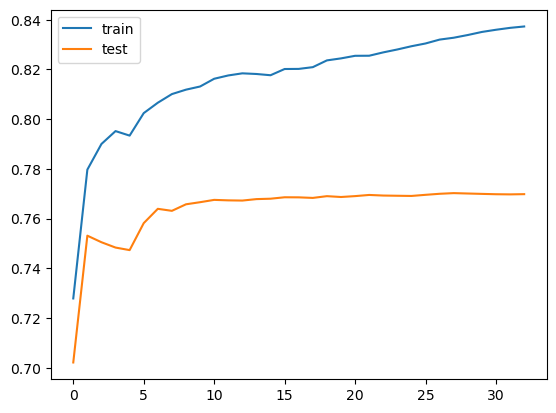

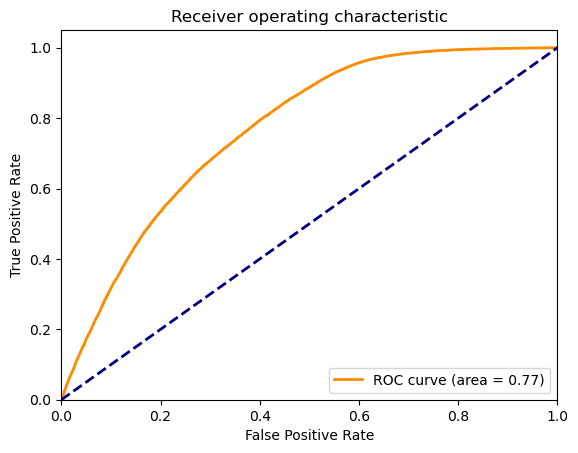

In [224]:
model = xgb.XGBClassifier()

model_path = './xgb_best_0.74.model'
model.load_model(model_path)

CalAuc(model)
CalROC(model)

In [227]:


# training eval
Score(model,X_train, y_train, X_test,y_test)
# testing eval
Score(model,X_train, y_train, X_test,y_test,train=False)

print('特徵重要程度: ',model.feature_importances_)

Train Result:

Accuracy Score: 67.21%
Precision Score: 32.24%
Recall Score: 86.28%
F1 score: 46.94%
Confusion Matrix:
 [[253690 146757]
 [ 11099  69811]]
Test Result:

Accuracy Score: 66.16%
Precision Score: 30.54%
Recall Score: 74.48%
F1 score: 43.32%
Confusion Matrix:
 [[90478 49991]
 [ 7532 21985]]
特徵重要程度:  [0.03991487 0.37259424 0.05336625 0.04685855 0.04334014 0.04810861
 0.21433972 0.04772542 0.04541459 0.04612957 0.04220805]


In [ ]:
# 這邊就不斷調要train 幾次 ,看recall score 
# **trial.params : 前面找出來的參數
# xgb_model = xgb.XGBClassifier(**trial.params)

# num =50 
# model_path = "./xgb_best_0.88.model"
# for i in range(num):
#     # xgb_model 讀檔的
#     xgb_model.fit(X_train, y_train,verbose=1,xgb_model=model_path)
#     # 存檔
#     xgb_model.save_model(model_path)


# Score(xgb_model,X_train, y_train, X_test,y_test)
# Score(xgb_model,X_train, y_train, X_test,y_test,train=False)